In [21]:
import ROOT as rt
# import root_numpy as rtnp
import csv
import re
import sys
import collections
import math
import os
from collections import OrderedDict
import uproot
import pandas as pd

import scipy
import awkward
import numpy as np
import time
import numba
from numba import jit
from matplotlib import pyplot as plt
sys.path.append('/storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/lib/')
sys.path.append('/storage/af/user/christiw/login-1/christiw/LLP/CMSSW_9_4_4/src/llp_analyzer/python/')

from histo_utilities import create_TH1D, create_TH2D, std_color_list, create_TGraph, make_ratio_plot
from helper import weight_calc

import CMS_lumi, tdrstyle
a = tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 0

print(sys.version)

3.6.8 (default, Aug  7 2019, 17:28:10) 
[GCC 4.8.5 20150623 (Red Hat 4.8.5-39)]


# Load ntuples

In [3]:
fpath =OrderedDict()
tree = OrderedDict()


start_t = time.time()



isData = 0

ntupler_version = 'V1p17/'
analyzer_version = "/v1/v86/"
#     analyzer_version = "/v1/v95/"
analyzer_version = "/v1/v100/"
analyzer_version = "/v1/v110/" #new acceptance definition
analyzer_version = "/v1/v138/" #new acceptance definition
analyzer_version = "/v1/v162/" #new acceptance definition

#     analyzer_version = "/v1/v110/" #new acceptance definition and no cuts at all


decay = 'dddd'
mass = [ '7', '15', '40','55']
ctaus  = ['100','1000','10000','100000']
# ctaus = ['10']
for ct in ctaus:
    for m in mass:
        mc_path = '/storage/af/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/'+ntupler_version+'/MC_all/'+analyzer_version+'/normalized/'
        fpath['m'+m+'ctau'+ct] = mc_path + 'ggH_HToSSTo'+decay+'_MH-125_MS-'+str(m)+'_ctau-'+ct+'_137000pb_weighted.root'

for k,v in fpath.items():
    print (k, v)
    root_dir = uproot.open(v) 
    tree[k] = root_dir['MuonSystem']
   



m7ctau100 /storage/af/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p17//MC_all//v1/v162//normalized/ggH_HToSSTodddd_MH-125_MS-7_ctau-100_137000pb_weighted.root
m15ctau100 /storage/af/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p17//MC_all//v1/v162//normalized/ggH_HToSSTodddd_MH-125_MS-15_ctau-100_137000pb_weighted.root
m40ctau100 /storage/af/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p17//MC_all//v1/v162//normalized/ggH_HToSSTodddd_MH-125_MS-40_ctau-100_137000pb_weighted.root
m55ctau100 /storage/af/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p17//MC_all//v1/v162//normalized/ggH_HToSSTodddd_MH-125_MS-55_ctau-100_137000pb_weighted.root
m7ctau1000 /storage/af/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p17//MC_all//v1/v162//normalized/ggH_HToSSTodddd_MH-125_MS-7_ctau-1000_137000pb_weighted.root
m15ctau1000 /storage/af/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p17//MC_all//v1/v162/

In [6]:
acceptance = {}
sel_ev = {}
accep_met = {}

sel_ev_cross = {}
sel_ev_csc2 = {}
sel_ev_dt2 = {}
sel_ev_csc1 = {}
sel_ev_dt1 = {}

acceptance_dt1 = {}
acceptance_csc1 = {}
acceptance_dt2 = {}
acceptance_csc2 = {}
acceptance_cross = {}
acceptance_2tag = {}
accep_met_dt1 = {}
accep_met_csc1 = {}
accep_met_dt2 = {}
accep_met_csc2 = {}
accep_met_cross = {}
accep_met_2tag = {}
weight = {}
higgsPtWeight = {}


for k, T in tree.items():
#     sel_dtcluster = T.array('dtRechitCluster_match_gLLP')
    sel_dt = np.logical_and(np.abs(T.array('gLLP_decay_vertex_z')) < 661, np.abs(T.array('gLLP_decay_vertex_r')) > 380)
    sel_dt = np.logical_and(sel_dt, np.abs(T.array('gLLP_decay_vertex_r')) <738 )
        
        
    sel_csc = np.logical_and(np.abs(T.array('gLLP_eta') < 2.4), np.abs(T.array('gLLP_decay_vertex_r')) < 695.5)
    sel_csc = np.logical_and(sel_csc, np.abs(T.array('gLLP_decay_vertex_z')) < 1100 )
    sel_csc = np.logical_and(sel_csc, np.abs(T.array('gLLP_decay_vertex_z')) > 661 )

    
    me11 = np.logical_and(np.abs(T.array('gLLP_eta') < 2.4), np.abs(T.array('gLLP_decay_vertex_r')) < 270)
    me11 = np.logical_and(me11, np.abs(T.array('gLLP_decay_vertex_z')) < 661 )
    me11 = np.logical_and(me11, np.abs(T.array('gLLP_decay_vertex_z')) > 500 )
    
    sel_csc = np.logical_or(sel_csc, me11) # definition to make sure no overlap
#     sel_csc = T.array('gLLP_csc') # definition for EXO-20-015

#     print(k, np.sum(np.logical_and(sel_csc,sel_dt).sum()))
    sel_ev_cross[k] = np.logical_and(np.sum(sel_csc,axis = 1) == 1, np.sum(sel_dt,axis = 1)==1)
    sel_ev_csc2[k] = np.sum(sel_csc,axis = 1) == 2
    sel_ev_dt2[k] =np.sum(sel_dt,axis = 1) == 2
    sel_ev_csc1[k] = np.sum(sel_csc,axis = 1) >= 1
    sel_ev_dt1[k] =np.sum(sel_dt,axis = 1) >= 1
# #     print(k, np.count_nonzero(np.sum(np.logical_and(sel_dt, sel_csc))))
#     if np.count_nonzero(sel_ev_dt2[k])>0:
#         print(k, np.count_nonzero(np.logical_and(sel_ev_dt2[k], T.array('nDtRechitClusters')>=2))/np.count_nonzero(sel_ev_dt2[k]))
#         print(k, np.count_nonzero( T.array('nDtRechitClusters')>=2)/len(sel_ev_dt2[k]))

    
    acceptance_dt1[k] = np.sum((T.array('weight')*T.array('higgsPtWeight'))[sel_ev_dt1[k]])/np.sum(T.array('weight'))
    acceptance_csc1[k] = np.sum((T.array('weight')*T.array('higgsPtWeight'))[sel_ev_csc1[k]])/np.sum(T.array('weight'))
    acceptance_dt2[k] = np.sum((T.array('weight')*T.array('higgsPtWeight'))[sel_ev_dt2[k]])/np.sum(T.array('weight'))
    acceptance_csc2[k] = np.sum((T.array('weight')*T.array('higgsPtWeight'))[sel_ev_csc2[k]])/np.sum(T.array('weight'))
    acceptance_cross[k] = np.sum((T.array('weight')*T.array('higgsPtWeight'))[sel_ev_cross[k]])/np.sum(T.array('weight'))
    acceptance_2tag[k] = acceptance_dt2[k] + acceptance_csc2[k] + acceptance_cross[k]


    
    
    sel_ev[k] = np.logical_and(T.array('metEENoise')>=200 ,T.array('METNoMuTrigger'))

    
    accep_met_dt1[k] = np.sum((T.array('weight')*T.array('higgsPtWeight'))[np.logical_and(sel_ev[k], sel_ev_dt1[k])])/np.sum(T.array('weight'))
    accep_met_csc1[k] = np.sum((T.array('weight')*T.array('higgsPtWeight'))[np.logical_and(sel_ev[k], sel_ev_csc1[k])])/np.sum(T.array('weight'))
    accep_met_dt2[k] = np.sum((T.array('weight')*T.array('higgsPtWeight'))[np.logical_and(sel_ev[k], sel_ev_dt2[k])])/np.sum(T.array('weight'))
    accep_met_csc2[k] = np.sum((T.array('weight')*T.array('higgsPtWeight'))[np.logical_and(sel_ev[k], sel_ev_csc2[k])])/np.sum(T.array('weight'))
    accep_met_cross[k] = np.sum((T.array('weight')*T.array('higgsPtWeight'))[np.logical_and(sel_ev[k], sel_ev_cross[k])])/np.sum(T.array('weight'))
    
    accep_met_2tag[k] = accep_met_dt2[k] + accep_met_csc2[k] + accep_met_cross[k]


#     print(k,'\t', acceptance_csc1[k],'\t', accep_met_csc1[k], np.sum(T.array('weight')))

# different mass points

In [29]:
plot_ctaus = ['10', '100','200', '500', '700', '1000','2000', '5000', '10000', '50000', '100000','1000000']


m7ctau100 6664848.5
m7ctau100 6664848.5
m7ctau1000 6664885.0
m7ctau100 6664848.5
m7ctau1000 6664885.0
m7ctau100 6664848.5
m7ctau1000 6664885.0
m7ctau1000 6664885.0
m7ctau10000 6664864.5
m7ctau1000 6664885.0
m7ctau10000 6664864.5
m7ctau10000 6664864.5
[     10     100     200     500     700    1000    2000    5000   10000
   50000  100000 1000000]
m15ctau100 6664865.0
m15ctau100 6664865.0
m15ctau1000 6664851.0
m15ctau100 6664865.0
m15ctau1000 6664851.0
m15ctau100 6664865.0
m15ctau1000 6664851.0
m15ctau1000 6664851.0
m15ctau10000 6664947.0
m15ctau1000 6664851.0
m15ctau10000 6664947.0
m15ctau10000 6664947.0
[     10     100     200     500     700    1000    2000    5000   10000
   50000  100000 1000000]
m40ctau1000 6664882.5
m40ctau1000 6664882.5
m40ctau1000 6664882.5
m40ctau1000 6664882.5
m40ctau10000 6664869.0
m40ctau1000 6664882.5
m40ctau10000 6664869.0
m40ctau10000 6664869.0
m40ctau100000 6664926.0
m40ctau100000 6664926.0
[     10     100     200     500     700    1000    2000    5

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


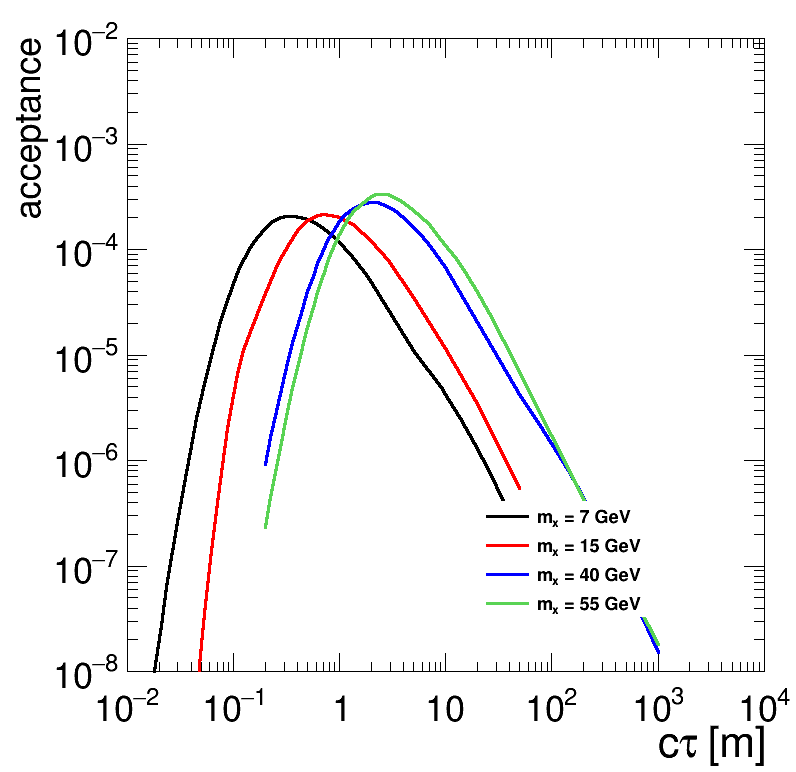

In [33]:




met = True

if met:
    variables = [accep_met_dt1,accep_met_csc1, accep_met_dt2, accep_met_csc2, accep_met_cross]
    
else: 
    variables = [acceptance_dt1, acceptance_csc1, acceptance_dt2, acceptance_csc2, acceptance_cross]
selections = [sel_ev_dt1, sel_ev_csc1, sel_ev_dt2, sel_ev_csc2, sel_ev_cross]
names = ['1 tag DT', '1 tag CSC', '2 tag DT', '2 tag CSC', '1 tag DT + 1 tag CSC']
names = ['1_tagDT', '1_tag_CSC', '2_tag_DT', '2_tag_CSC', '1_DT_1_CSC']
names= ['dt1', 'csc1', 'dt2', 'csc2', 'dt1csc1']


for j, var in enumerate(variables):
    if not j == 2:continue
    leg = rt.TLegend(0.6,0.2,0.9,0.35)
    leg.SetTextSize(0.025)
    leg.SetBorderSize(0)
    leg.SetEntrySeparation(0.01)
    c = rt.TCanvas('c','c', 800, 800)
    c.SetRightMargin(0.04)
    
    rt.gStyle.SetOptFit(1011)
    h = {}
    
    for i, m in enumerate(mass):
#         y = np.array([var['m'+m+'ctau100'], var['m'+m+'ctau1000'], var['m'+m+'ctau10000'], var['m'+m+'ctau100000']])
#         x = np.array([int(a) for a in ctaus])
        x = []
        y = []
        for ct in plot_ctaus:
            if ct in ctaus:
                x.append(int(ct))
                y.append(var['m'+m+'ctau'+ct])
            else:
                
                ctf = int(ct)
                ct_list = 10**int(math.log10(ctf))

                if ctf < int(ctaus[0]): ct_list = [int(ctaus[0])]
                elif ctf > int(ctaus[-1]): ct_list = [int(ctaus[-1])]
                elif ct in ctaus: ct_list = [ctf]
                else:ct_list = [ct_list,ct_list*10]
                sig = 0
                for l, ct0 in enumerate(ct_list):
                    
                    k = 'm'+m+'ctau'+str(ct0)
                    T = tree[k]
#                     print(var.keys())
#                     print(var[k])
                    if var[k] == 0:continue
                    if met: cond = np.logical_and(sel_ev[k], selections[j][k])
                    else: cond = selections[j][k]
                    gLLP_ctau = T.array('gLLP_ctau')[cond]

                    weight_ctau = weight_calc(gLLP_ctau, ctf/10, int(ct0)/10) # convert everything to cm
                    gLLP_ctau = np.sum(T.array('gLLP_ctau'), axis = 1)[cond]
                    if len(ct_list) == 1:weight_cond = gLLP_ctau >= 0
                    else:
                        if l == 0 : weight_cond = gLLP_ctau<int(ct_list[0]/2)
                        else: weight_cond = gLLP_ctau>=int(ct_list[0]/2)
                    sig += np.sum((T.array('weight')*T.array('higgsPtWeight'))[cond][weight_cond]*weight_ctau[weight_cond])
                    print(k, np.sum(T.array('weight')))
                x.append(int(ct))
                y.append(sig/np.sum(T.array('weight')))
                

                    
        x = np.array(x)
        y = np.array(y)
        cond = y>0.0
        print(x)
        h[m+str(j)] = create_TGraph(x[cond]/1000.0, y[cond],  axis_title=['c#tau [m]', 'acceptance'])


        h[m+str(j)].SetLineColor(std_color_list[i])
        h[m+str(j)].SetLineWidth(3)
        h[m+str(j)].GetXaxis().SetTitleOffset(1)
        h[m+str(j)].GetYaxis().SetTitleSize(0.05)
        h[m+str(j)].GetYaxis().SetTitleOffset(1.5)
        h[m+str(j)].GetXaxis().SetLimits(0.01,10000.0)
        if met:h[m+str(j)].GetYaxis().SetRangeUser(1e-8,0.01)
        else: h[m+str(j)].GetYaxis().SetRangeUser(1e-7,1)
        leg.AddEntry(h[m+str(j)], "m_{x} = "+str(m)+" GeV", "L")


    for i,m in enumerate(h.keys()):
        h[m].Draw('CA' if i == 0 else 'Csame')
#         h[m].Draw('LA' if i == 0 else 'Lsame')



    leg.Draw()
    c.SetLogy()
    c.SetLogx()
    c.SetTicky(1)
    c.SetTickx(1)
    if met: output_dir = '/storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/dt/acceptance_met/'
    else: output_dir = '/storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/dt/acceptance/'
    if not os.path.isdir(output_dir):os.makedirs(output_dir)
    name = output_dir+names[j]
    print(name)


#     c.SaveAs(name+'.png')
#     c.SaveAs(name+'.C')
#     c.SaveAs(name+'.pdf')
    c.Draw()




In [40]:
plot_ctaus = ['10', '100', '200', '300', '400', '500','600', '700','800','900', '1000', '5000', '10000', '50000', '100000','1000000']


# different detector same mass

In [42]:
import os


met = False
total = False

met = True
selections = [sel_ev_dt1, sel_ev_csc1, sel_ev_dt2, sel_ev_csc2, sel_ev_cross]

# if met:
#     variables = [accep_met_dt1,accep_met_csc1, accep_met_dt2, accep_met_csc2, accep_met_cross]
    
# else: 
#     variables = [acceptance_dt1, acceptance_csc1, acceptance_dt2, acceptance_csc2, acceptance_cross]
# selections = [sel_ev_dt1, sel_ev_csc1, sel_ev_dt2, sel_ev_csc2, sel_ev_cross]
# names = ['1 tag DT', '1 tag CSC', '2 tag DT', '2 tag CSC', '1 tag DT + 1 tag CSC']
# names = ['1_tagDT', '1_tag_CSC', '2_tag_DT', '2_tag_CSC', '1_DT_1_CSC']
# names= ['dt1', 'csc1', 'dt2', 'csc2', 'dt1csc1']



if total:
    names = ['1 tag DT', '1 tag CSC', '2 tag ']
    if met:variables = [accep_met_dt1,accep_met_csc1, accep_met_2tag]
    else: variables = [acceptance_dt1, acceptance_csc1, acceptance_2tag]



else:
    names = ['1 tag DT', '1 tag CSC', '2 tag DT', '2 tag CSC', '1 tag DT + 1 tag CSC']
    if met:variables = [accep_met_dt1,accep_met_csc1, accep_met_dt2, accep_met_csc2, accep_met_cross]
    else: variables = [acceptance_dt1, acceptance_csc1, acceptance_dt2, acceptance_csc2, acceptance_cross]
    
    

for j, m in enumerate(mass):
    
    if not j == 1:continue
    c = rt.TCanvas('c','c', 800, 800)
    c.SetRightMargin(0.04)
    rt.gStyle.SetOptFit(1011)
    leg = rt.TLegend(0.6,0.2,0.9,0.35)
    leg.SetTextSize(0.025)
    leg.SetBorderSize(0)
    leg.SetEntrySeparation(0.01)
    h = {}
    x = {}
    y = {}
    for i, var in enumerate(variables):

        print(i)
        x[i] = []
        y[i] = []
        for ct in plot_ctaus:
            if ct in ctaus:
                x[i].append(int(ct))
                y[i].append(var['m'+m+'ctau'+ct])
            else:
                
                ctf = int(ct)
                ct_list = 10**int(math.log10(ctf))

                if ctf < int(ctaus[0]): ct_list = [int(ctaus[0])]
                elif ctf > int(ctaus[-1]): ct_list = [int(ctaus[-1])]
                elif ct in ctaus: ct_list = [ctf]
                else:ct_list = [ct_list,ct_list*10]
                sig = 0
                for l, ct0 in enumerate(ct_list):
                    
                    k = 'm'+m+'ctau'+str(ct0)
                    T = tree[k]
#                     print(var.keys())
#                     print(var[k])
                    if var[k] == 0:continue
                    if met: cond = np.logical_and(sel_ev[k], selections[i][k])
                    else: cond = selections[i][k]
                    gLLP_ctau = T.array('gLLP_ctau')[cond]

                    weight_ctau = weight_calc(gLLP_ctau, ctf/10, int(ct0)/10) # convert everything to cm
                    gLLP_ctau = np.sum(T.array('gLLP_ctau'), axis = 1)[cond]
                    if len(ct_list) == 1:weight_cond = gLLP_ctau >= 0
                    else:
                        if l == 0 : weight_cond = gLLP_ctau<int(ct_list[0]/2)
                        else: weight_cond = gLLP_ctau>=int(ct_list[0]/2)
                    sig += np.sum((T.array('weight')*T.array('higgsPtWeight'))[cond][weight_cond]*weight_ctau[weight_cond])
                x[i].append(int(ct))
                y[i].append(sig/np.sum(T.array('weight')))
                

                    
        x[i] = np.array(x[i])
        y[i] = np.array(y[i])
       
        h[m+'twotag'] = create_TGraph((x[2]+x[3]+x[4])/1000.0, (y[2]+y[3]+y[4]),  axis_title=['c#tau [m]', 'geometric acceptance'])


        h[m+'twotag'].SetLineColor(std_color_list[i+1])
        h[m+'twotag'].SetLineWidth(3)
        
        
        leg.AddEntry(h[m+'twotag'], 'Double cluster', "L")

    #### add sum of two tag
    cond = y>0.0
    h[m+str(i)] = create_TGraph(x[cond]/1000.0, y[cond],  axis_title=['c#tau [m]', 'geometric acceptance'])


    h[m+str(i)].SetLineColor(std_color_list[i])
    h[m+str(i)].SetLineWidth(3)
    h[m+str(i)].GetXaxis().SetTitleOffset(1)
    h[m+str(i)].GetYaxis().SetTitleSize(0.05)
    h[m+str(i)].GetYaxis().SetTitleOffset(1.5)
    h[m+str(i)].GetXaxis().SetLimits(0.01,10000.0)
    if met:h[m+str(i)].GetYaxis().SetRangeUser(1e-8,0.01)
    else: h[m+str(i)].GetYaxis().SetRangeUser(1e-7,1)
    leg.AddEntry(h[m+str(i)], names[i], "L")
        
        
    for i,k in enumerate(h.keys()):
#         h[k].Draw('CA' if i == 0 else 'Csame')
        h[k].Draw('LA' if i == 0 else 'Lsame')

    leg.Draw()
    c.SetLogy()
    c.SetLogx()
    c.SetTicky(1)
    c.SetTickx(1)
    
    if met: output_dir = '/storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/dt/acceptance_met/'
    else: output_dir = '/storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/dt/acceptance/'
    if not os.path.isdir(output_dir):os.makedirs(output_dir)
    name = output_dir+'mass'+m

#     if total:
#         c.SaveAs(name+'_2tagtotal.png')
#         c.SaveAs(name+'_2tagtotal.C')
#         c.SaveAs(name+'_2tagtotal.pdf')
#     else:
#         c.SaveAs(name+'.png')
#         c.SaveAs(name+'.C')
#         c.SaveAs(name+'.pdf')

    c.Draw()





0


KeyError: 2

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


[   100   1000  10000 100000] [0.00051871 0.00245022 0.0008714  0.00010995]
[   100   1000  10000 100000] [6.1465416e-04 1.6119396e-03 5.4284831e-04 6.6587017e-05]
[   100   1000  10000 100000] [2.8408962e-05 4.3636872e-04 2.3566145e-05 4.5320724e-07]
[   100   1000  10000 100000] [2.7982485e-06 2.0721632e-04 1.0815684e-05 2.7317640e-07]
[   100   1000  10000 100000] [2.4624309e-05 8.4504209e-05 3.6569836e-06 1.8003082e-07]
[   100   1000  10000 100000] [9.8640521e-07 1.4464819e-04 9.0934773e-06 0.0000000e+00]


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


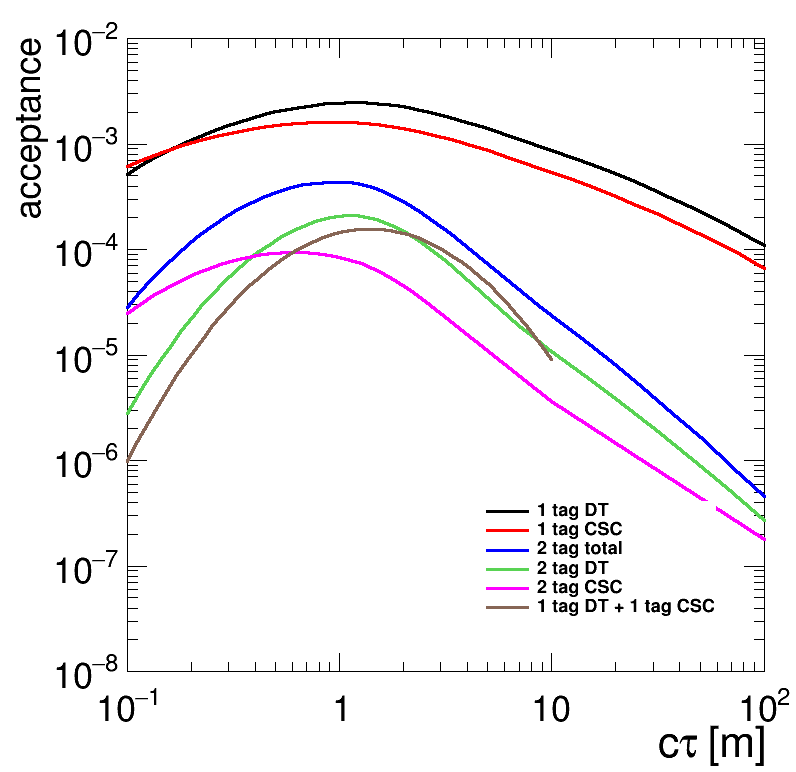

In [6]:
import os


met = 1


names = ['1 tag DT', '1 tag CSC', '2 tag total', '2 tag DT', '2 tag CSC', '1 tag DT + 1 tag CSC']
if met:variables = [accep_met_dt1,accep_met_csc1, accep_met_2tag, accep_met_dt2, accep_met_csc2, accep_met_cross]
else: variables = [acceptance_dt1, acceptance_csc1, acceptance_2tag, acceptance_dt2, acceptance_csc2, acceptance_cross]
    
    

for j, m in enumerate(mass):
    
    if not m == '15':continue
    c = rt.TCanvas('c','c', 800, 800)
    c.SetRightMargin(0.04)
    rt.gStyle.SetOptFit(1011)
    leg = rt.TLegend(0.6,0.2,0.9,0.35)
    leg.SetTextSize(0.025)
    leg.SetBorderSize(0)
    leg.SetEntrySeparation(0.01)
    h = {}
    for i, var in enumerate(variables):


        y = np.array([var['m'+m+'ctau100'], var['m'+m+'ctau1000'], var['m'+m+'ctau10000'], var['m'+m+'ctau100000']])
        x = np.array([int(a) for a in ctaus])
        
        cond = y>0.0
        print(x, y)
        h[m+str(i)] = create_TGraph(x[cond]/1000.0, y[cond],  axis_title=['c#tau [m]', 'acceptance'])


        h[m+str(i)].SetLineColor(std_color_list[i])
        h[m+str(i)].SetLineWidth(3)
        h[m+str(i)].GetXaxis().SetTitleOffset(1)
        h[m+str(i)].GetYaxis().SetTitleSize(0.05)
        h[m+str(i)].GetYaxis().SetTitleOffset(1.5)
        h[m+str(i)].GetXaxis().SetLimits(0.1,100.0)
        if met:h[m+str(i)].GetYaxis().SetRangeUser(1e-8,0.01)
        else: h[m+str(i)].GetYaxis().SetRangeUser(1e-7,1)
        leg.AddEntry(h[m+str(i)], names[i], "L")


    for i,k in enumerate(h.keys()):
        h[k].Draw('CA' if i == 0 else 'Csame')

    leg.Draw()
    c.SetLogy()
    c.SetLogx()
    c.SetTicky(1)
    c.SetTickx(1)
    
#     if met: output_dir = '/storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/dt/acceptance_met/'
#     else: output_dir = '/storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/dt/acceptance/'
#     if not os.path.isdir(output_dir):os.makedirs(output_dir)
#     name = output_dir+'mass'+m

#     if total:
#         c.SaveAs(name+'_all.png')
#         c.SaveAs(name+'_all.C')
#         c.SaveAs(name+'_all.pdf')
#     else:
#         c.SaveAs(name+'.png')
#         c.SaveAs(name+'.C')
#         c.SaveAs(name+'.pdf')

    c.Draw()






# hepdata plot for EXO-20-015

[       5       10       15       20       30       40       50       60
      100      125      150      200      300      500      600      700
      800      900     1000     2000     3000     4000     5000     6000
     7000     8000    10000    20000    30000    50000   100000   200000
   300000   500000  1000000  2000000  3000000  5000000  6000000 10000000]
[       5       10       15       20       30       40       50       60
      100      125      150      200      300      500      600      700
      800      900     1000     2000     3000     4000     5000     6000
     7000     8000    10000    20000    30000    50000   100000   200000
   300000   500000  1000000  2000000  3000000  5000000  6000000 10000000]
[       5       10       15       20       30       40       50       60
      100      125      150      200      300      500      600      700
      800      900     1000     2000     3000     4000     5000     6000
     7000     8000    10000    20000    30000    

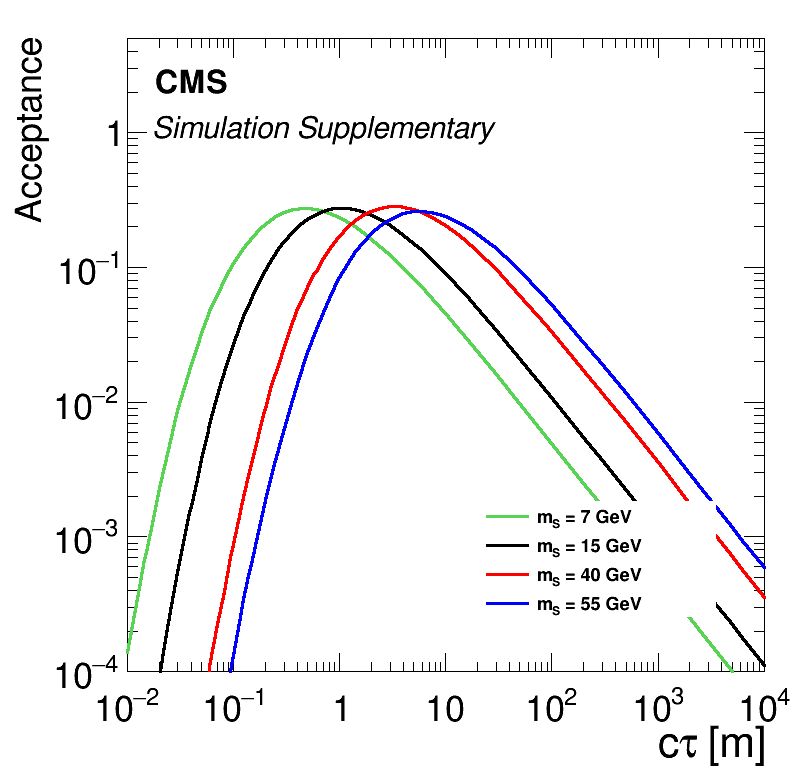

In [4]:
import numpy.ma as ma
import ROOT as rt
import os
import importlib
import math
sys.path.append('/storage/af/user/christiw/login-1/christiw/LLP/CMSSW_9_4_4/src/llp_analyzer/python/')

from helper import  weight_calc

importlib.reload(sys.modules['CMS_lumi'])


OLD_CTAU= [100,1000,10000,100000]



leg = rt.TLegend(0.6,0.2,0.9,0.35)
leg.SetTextSize(0.025)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)
c = rt.TCanvas('c','c', 800, 800)
c.SetRightMargin(0.04)
rt.gStyle.SetOptFit(1011)
h = {}

ctaus = ['5','10','15','20','30','40', '50','60', '100', '125','150','200','300','500','600','700','800','900','1000', '2000','3000','4000', '5000', '6000','7000','8000','10000', '20000','30000','50000',\
         '100000', '200000', '300000', '500000', '1000000', '2000000', '3000000', '5000000', '6000000', '10000000'] #mm
acceptance = {}

for i, m in enumerate(mass):
    acceptance[m] = []
    #ctau reweighting
    for ct in ctaus:
        accep_temp = 0
        ctf = int(ct)
        ct_list = 10**int(math.log10(ctf))
        if ctf < OLD_CTAU[0]: ct_list = [OLD_CTAU[0]]
        elif ctf>OLD_CTAU[-1]: ct_list = [OLD_CTAU[-1]]
        elif ct_list == int(ct): ct_list = [int(ct)]
        else:ct_list = [ct_list,ct_list*10]
   
        
        for j, ct0 in enumerate(ct_list):
            k = 'm'+str(m)+'ctau'+str(ct0)
            T = tree[k]
            if np.count_nonzero(sel_ev_csc1[k])==0:continue
            gLLP_ctau = T.array('gLLP_ctau')[sel_ev_csc1[k]]
            weight_ctau = weight_calc(gLLP_ctau, int(ct)/10, int(ct0)/10) # convert everything to cm
            gLLP_ctau = np.sum(T.array('gLLP_ctau'), axis = 1)[sel_ev_csc1[k]]
            if len(ct_list) == 1:weight_cond = gLLP_ctau >= 0
            else:
                if j == 0 : weight_cond = gLLP_ctau<int(ct_list[0]/2)
                else: weight_cond = gLLP_ctau>=int(ct_list[0]/2)
            weight = (T.array('weight')*T.array('higgsPtWeight'))[sel_ev_csc1[k]]
            w = (weight*weight_ctau)[weight_cond]
            accep_temp += np.sum(w)
        acceptance[m].append(accep_temp/6664892.0)
#         print(ct, m, acceptance[m][-1])
    
    #######################
    
#     y = np.array([acceptance_csc1['m'+m+'ctau100'], acceptance_csc1['m'+m+'ctau1000'], acceptance_csc1['m'+m+'ctau10000'], acceptance_csc1['m'+m+'ctau100000']])
    x = np.array([int(a) for a in ctaus])
    y = np.array(acceptance[m])
    cond = y>0.0
    print(x)
    h[m] = create_TGraph(x[cond]/1000.0, y[cond],  axis_title=['c#tau [m]', 'Acceptance'])


    if i == 0:h[m].SetLineColor(std_color_list[3])
    else:h[m].SetLineColor(std_color_list[i-1])

    h[m].SetLineWidth(3)
    h[m].GetXaxis().SetTitleOffset(1)
    h[m].GetYaxis().SetTitleSize(0.05)
    h[m].GetYaxis().SetTitleOffset(1.5)
    h[m].GetXaxis().SetLimits(0.01,10000.0)
    h[m].GetYaxis().SetRangeUser(1e-4,5)
    leg.AddEntry(h[m], "m_{S} = "+str(m)+" GeV", "L")

    
    ###### save to text file for hepdata ######
    outputDir = '/storage/af/user/christiw/login-1/christiw/LLP/CMSSW_9_4_4/src/llp_analyzer/data/SupplementaryMaterials/'
    if not os.path.isdir(outputDir):os.makedirs(outputDir)
    outputFileName = outputDir + 'acceptance_m'+str(m)
    outputFileName += '.txt'
    np.savetxt(outputFileName, np.column_stack((x[cond]/1000.0, y[cond])), delimiter="\t")


for i,m in enumerate(h.keys()):
    h[m].Draw('CA' if i == 0 else 'Csame')
#     h[m].Draw('LA' if i == 0 else 'Lsame')

CMS_lumi.cmsText     = "CMS"
CMS_lumi.iPos=11
CMS_lumi.relPosX = 0.1
CMS_lumi.relPosY = 0.05        
CMS_lumi.writeExtraText = 1
CMS_lumi.extraText   = "Simulation Supplementary"
CMS_lumi.CMS_lumi(c, 0, 11)

leg.Draw()


c.SetLogy()
c.SetLogx()
c.SetTicky(1)
c.SetTickx(1)
# output_dir = '/storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/csc/acceptance/'
# if not os.path.isdir(output_dir):os.makedirs(output_dir)
    
# name = output_dir+names[j]
# print(name)


#     c.SaveAs(name+'.png')
#     c.SaveAs(name+'.C')
#     c.SaveAs(name+'.pdf')
c.Draw()





Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/acceptance/csc_acceptance.png has been created
Info in <TCanvas::SaveSource>: C++ Macro file: /storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/acceptance/csc_acceptance.C has been generated
Info in <TCanvas::Print>: pdf file /storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/acceptance/csc_acceptance.pdf has been created


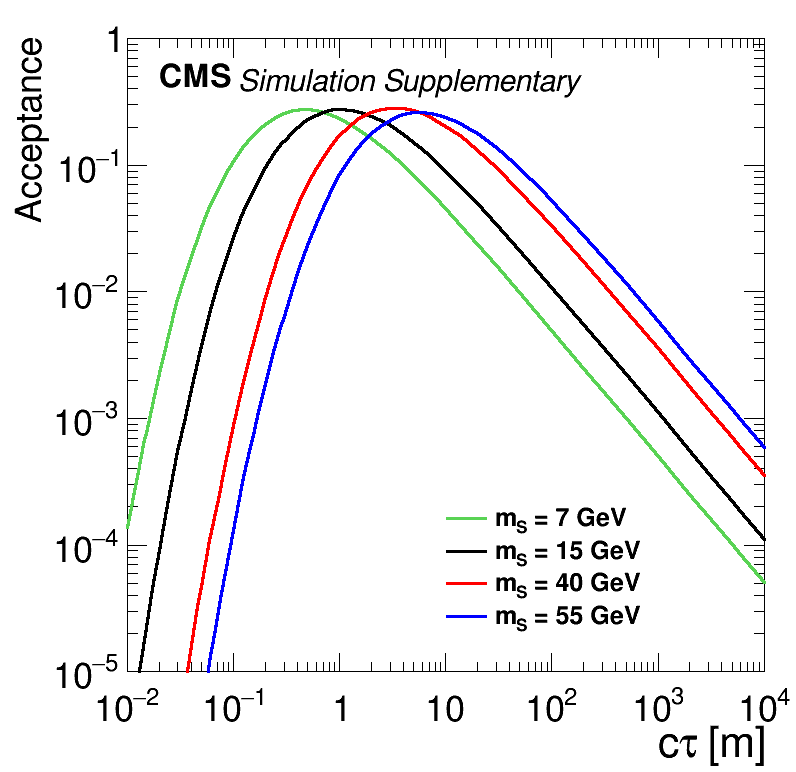

In [14]:
importlib.reload(sys.modules['CMS_lumi'])


leg = rt.TLegend(0.55,0.18,0.84,0.35)
# leg = rt.TLegend(0.7,0.75,0.84,0.9)
leg.SetTextSize(0.035)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)

c = rt.TCanvas('c','c', 800, 800)
c.SetRightMargin(0.04)
rt.gStyle.SetOptFit(1011)
for i,m in enumerate(h.keys()):
    if i == 0:h[m].SetLineColor(std_color_list[3])
    else:h[m].SetLineColor(std_color_list[i-1])
#     h[m].GetXaxis().SetLimits(0.01,10000.0)
    h[m].GetYaxis().SetRangeUser(1e-5,1)
    leg.AddEntry(h[m], "m_{S} = "+str(m)+" GeV", "L")

    h[m].Draw('CA' if i == 0 else 'Csame')
#     h[m].Draw('LA' if i == 0 else 'Lsame')


CMS_lumi.cmsText     = "CMS"
CMS_lumi.iPos=11
CMS_lumi.relPosX = 0.05
CMS_lumi.relPosY = 0.041      
CMS_lumi.writeExtraText = 1
CMS_lumi.extraText   = "Simulation Supplementary"
CMS_lumi.CMS_lumi(c, 0, 10)

leg.Draw()


c.SetLogy()
c.SetLogx()
c.SetTicky(1)
c.SetTickx(1)
output_dir = '/storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/acceptance/'
if not os.path.isdir(output_dir):os.makedirs(output_dir)
    
# name = output_dir+names[j]
# print(name)


c.SaveAs(output_dir+'csc_acceptance.png')
c.SaveAs(output_dir+'csc_acceptance.C')
c.SaveAs(output_dir+'csc_acceptance.pdf')
c.Draw()



